- seq2seq에선느 key value 동일
- 워드 임베딩 벤치마크
- 언어모델 평가 : perplexity
- https://wikidocs.net/72820
- https://github.com/philipperemy/keras-attention-mechanism

# 바다나우 어텐션을 사용한 seq2seq 만들기

앞서 배운 seq2seq 모델은 인코더에서 입력 시퀀스를 컨텍스트 벡터라는 하나의 고정된 크기의 벡터 표현으로 압축하고, 디코더는 이 컨텍스트 벡터를 통해서 출력 시퀀스를 만들어냈습니다.

하지만 이러한 RNN에 기반한 seq2seq 모델에는 크게 두 가지 문제가 있습니다.
첫째, 하나의 고정된 크기의 벡터에 모든 정보를 압축하려고 하니까 정보 손실이 발생합니다.
둘째, RNN의 고질적인 문제인 기울기 소실(Vanishing Gradient) 문제가 존재합니다.

즉, 결국 이는 기계 번역 분야에서 입력 문장이 길면 번역 품질이 떨어지는 현상으로 나타났습니다. 이를 위한 대안으로 입력 시퀀스가 길어지면 출력 시퀀스의 정확도가 떨어지는 것을 보정해주기 위한 등장한 기법인 어텐션(attention)을 소개합니다.
1. 어텐션(Attention)의 아이디어
어텐션의 기본 아이디어는 디코더에서 출력 단어를 예측하는 매 시점(time step)마다, 인코더에서의 전체 입력 문장을 다시 한 번 참고한다는 점입니다. 단, 전체 입력 문장을 전부 다 동일한 비율로 참고하는 것이 아니라, 해당 시점에서 예측해야할 단어와 연관이 있는 입력 단어 부분을 좀 더 집중(attention)해서 보게 됩니다.

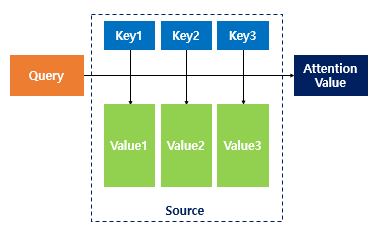
어텐션 함수는 주어진 '쿼리(Query)'에 대해서 모든 '키(Key)'와의 유사도를 각각 구합니다. 그리고 구해낸 이 유사도를 키와 맵핑되어있는 각각의 '값(Value)'에 반영해줍니다. 그리고 유사도가 반영된 '값(Value)'을 모두 더해서 리턴합니다. 여기서는 이를 어텐션 값(Attention Value)이라고 하겠습니다.
Q = Query : t 시점의 디코더 셀에서의 은닉 상태
K = Keys : 모든 시점의 인코더 셀의 은닉 상태들
V = Values : 모든 시점의 인코더 셀의 은닉 상태들
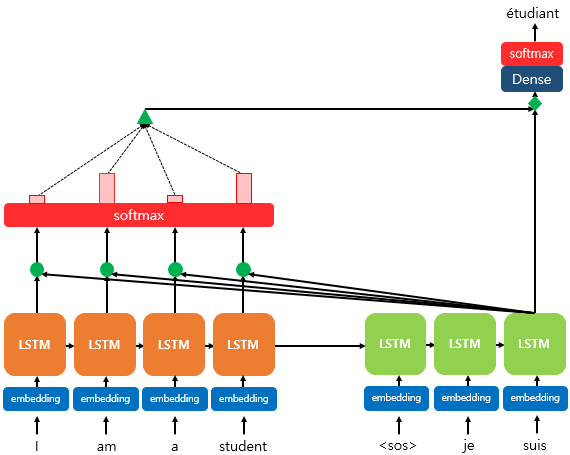
소프트맥스 함수를 통해 나온 결과값은 I, am, a, student 단어 각각이 출력 단어를 예측할 때 얼마나 도움이 되는지의 정도를 수치화한 값입니다. 위의 그림에서는 빨간 직사각형의 크기로 소프트맥스 함수의 결과값의 크기를 표현했습니다. 직사각형의 크기가 클 수록 도움이 되는 정도의 크기가 큽니다. 각 입력 단어가 디코더의 예측에 도움이 되는 정도가 수치화하여 측정되면 이를 하나의 정보로 담아서 디코더로 전송됩니다. 위의 그림에서는 초록색 삼각형이 이에 해당됩니다. 결과적으로, 디코더는 출력 단어를 더 정확하게 예측할 확률이 높아집니다.
![image-3.png](https://wikidocs.net/images/page/22893/dotproductattention2_final.PNG)
- 인코더의 시점(time step)을 각각 1, 2, ... N이라고 하였을 때 인코더의 은닉 상태(hidden state)를 각각 h1, h2, ... hN라고 합시다. 디코더의 현재 시점(time step) t에서의 디코더의 은닉 상태(hidden state)를 st라고 합시다. 또한 여기서는 인코더의 은닉 상태와 디코더의 은닉 상태의 차원이 같다고 가정합니다. 위의 그림의 경우에는 인코더의 은닉 상태와 디코더의 은닉 상태가 동일하게 차원이 4입니다.
- 어텐션 메커니즘의 첫 걸음인 어텐션 스코어(Attention score)에 대해서 배우기전에, 이전 챕터에서 배웠던 디코더의 현재 시점 t에서 필요한 입력값을 다시 상기해보겠습니다. 시점 t에서 출력 단어를 예측하기 위해서 디코더의 셀은 두 개의 입력값을 필요로 하는데, 바로 이전 시점인 t-1의 은닉 상태와 이전 시점 t-1에 나온 출력 단어입니다.
- 그런데 어텐션 메커니즘에서는 출력 단어 예측에 또 다른 값을 필요로 하는데 바로 어텐션 값(Attention Value)이라는 새로운 값입니다. t번째 단어를 예측하기 위한 어텐션 값을 at이라고 정의하겠습니다.
- 어텐션 스코어란 현재 디코더의 시점 t에서 단어를 예측하기 위해, 인코더의 모든 은닉 상태 각각이 디코더의 현 시점의 은닉 상태 st와 얼마나 유사한지를 판단하는 스코어값입니다.
- 닷-프로덕트 어텐션에서는 이 스코어 값을 구하기 위해 st를 전치(transpose)하고 각 은닉 상태와 내적(dot product)을 수행합니다. 즉, 모든 어텐션 스코어 값은 스칼라입니다.
$$score(s_{t},\ h_{i}) = s_{t}^Th_{i}$$
- st 와 인코더의 모든 은닉 상태의 어텐션 스코어의 모음값을 et라고 정의하겠습니다. et의 수식은 다음과 같습니다.
$$e^{t}=[s_{t}^Th_{1},...,s_{t}^Th_{N}]$$
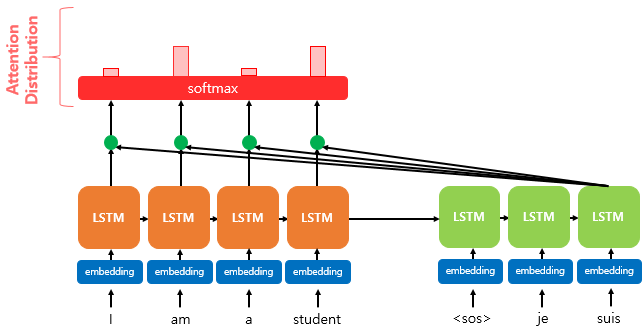
- $e^{t}$ 에 소프트맥스 함수를 적용하여, 모든 값을 합하면 1이 되는 확률 분포를 얻어냅니다. 이를 어텐션 분포(Attention Distribution)라고 하며, 각각의 값은 어텐션 가중치(Attention Weight)라고 합니다. 예를 들어 소프트맥스 함수를 적용하여 얻은 출력값인 I, am, a, student의 어텐션 가중치를 각각 0.1, 0.4, 0.1, 0.4라고 합시다. 이들의 합은 1입니다. 위의 그림은 각 인코더의 은닉 상태에서의 어텐션 가중치의 크기를 직사각형의 크기를 통해 시각화하였습니다. 즉, 어텐션 가중치가 클수록 직사각형이 큽니다.
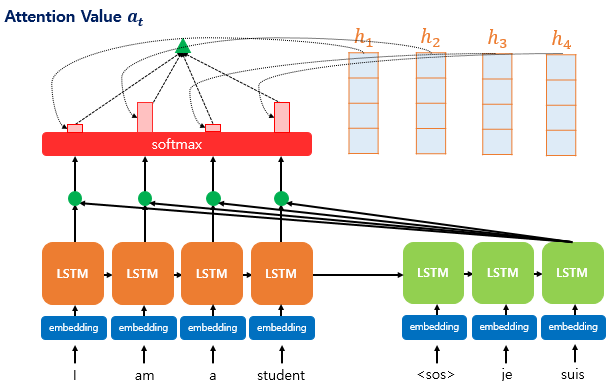
- 이제 지금까지 준비해온 정보들을 하나로 합치는 단계입니다. 어텐션의 최종 결과값을 얻기 위해서 각 인코더의 은닉 상태와 어텐션 가중치값들을 곱하고, 최종적으로 모두 더합니다. 요약하면 가중합(Weighted Sum)을 한다고 말할 수도 있겠습니다. 아래는 어텐션의 최종 결과. 즉, 어텐션 함수의 출력값인 어텐션 값(Attention Value) at에 대한 식을 보여줍니다.
at=∑i=1Nαtihi
이러한 어텐션 값 at은 종종 인코더의 문맥을 포함하고 있다고하여, 컨텍스트 벡터(context vector)라고도 불립니다. 앞서 배운 가장 기본적인 seq2seq에서는 인코더의 마지막 은닉 상태를 컨텍스트 벡터라고 부르는 것과 대조됩니다.

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
import unicodedata
import re
import numpy as np
import os
import io
import time
import wget

## 데이터 로드

In [4]:
wget.download('http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip')

 85% [...............................................................           ] 2252800 / 2638744

100% [..........................................................................] 2638744 / 2638744

'spa-eng.zip'

In [ ]:
path_to_zip = tf.keras.utils.get_file('spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip', extract=True)
path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

2646016/2638744 [==============================] - 0s 0us/step


## 전처리

In [ ]:
# 유니코드를 아스키로 변환
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    # 단어와 특수 문자 사이에 공백 넣기
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # 영어와 일부 특수문자(a-z, A-Z, ".", "?", "!", ",")를 제외하고는 전부 공백으로 변환
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.strip()

    # 문장의 시작과 끝에 <start> 토큰화 <end> 토큰 추가
    w = '<start> ' + w + ' <end>'
    return w

In [ ]:
# 임의 선정한 문장에 대해서 전처리 결과 확인
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))

<start> may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


## 토큰화 / 정수 인코딩 / 패딩

In [ ]:
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]
    return zip(*word_pairs)

In [ ]:
# 지금까지 선언한 전처리 함수들을 실제 데이터셋에 적용한다면?
en, sp = create_dataset(path_to_file, None)
print(en[-1])
print(sp[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [ ]:
# 토큰화 / 정수 인코딩 / 패딩을 하는 함수
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
    lang_tokenizer.fit_on_texts(lang)

    tensor = lang_tokenizer.texts_to_sequences(lang)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

    return tensor, lang_tokenizer

In [ ]:
# 입력된 데이터셋에 대해서 토큰화 / 정수 인코딩 / 패딩을 수행
def load_dataset(path, num_examples=None):
    # creating cleaned input, output pairs
    targ_lang, inp_lang = create_dataset(path, num_examples)

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [ ]:
# 샘플 수는 3만개로 제한하며
# 실제로 토큰화, 정수 인코딩, 패딩을 수행
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# 최대 길이 계산
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [ ]:
# 8:2 비율로 분할
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# 샘플 개수
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

24000 24000 6000 6000


In [ ]:
input_tensor_train[0]

array([   1,   28,   99, 1541,    3,    2,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0], dtype=int32)

In [ ]:
target_tensor_train[0]

array([   1,   20,  137,   35, 1256,    3,    2,    0,    0,    0,    0],
      dtype=int32)

In [ ]:
input_tensor_val[0]

array([  1,  29, 146, 297,   3,   2,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0], dtype=int32)

In [ ]:
target_tensor_val[0]

array([  1,   4, 117,   6, 363,   3,   2,   0,   0,   0,   0], dtype=int32)

In [ ]:
def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, lang.index_word[t]))

In [ ]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
28 ----> eso
99 ----> parece
1541 ----> sangre
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
20 ----> that
137 ----> looks
35 ----> like
1256 ----> blood
3 ----> .
2 ----> <end>


## 텐서플로우 데이터셋 생성

In [ ]:
# 하이퍼파라미터 정의
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024

# 단어 집합의 크기 정의
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

# 데이터셋 생성
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
# 첫번째 배치에 대해서 크기 출력
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 16]), TensorShape([64, 11]))

## 인코더 구현

In [ ]:
# 인코더 구현
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        # 선언부
        self.batch_sz = batch_sz
        self.enc_units = enc_units

        # 임베딩 층
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)

        # GRU
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  # 함수형 API와 유사하게 실제 동작은 이곳에서 정의
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

  # 초기 은닉 상태는 제로 벡터로 사용
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [ ]:
# 인코더 구현
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

In [ ]:
# 제로 벡터 생성
sample_hidden = encoder.initialize_hidden_state()

# 임의의 테스트 입력과 제로 벡터를 입력
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)

# (64, 16, 1024)는 각각 (배치 크기, 문장 길이, 은닉 상태의 차원)
# (64, 1024)는 각각 (배치 크기, 은닉 상태의 차원)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 16, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


## 바다나우 어텐션 구현
- 여기서 사용할 어텐션은 바다나우 어텐션(Bahdanau attention)입니다. 이를 이해하기 위해 앞서 배운 가장 쉬운 어텐션이었던 닷 프로덕트 어텐션과 어텐션 스코어 함수의 정의를 상기해봅시다.

어텐션 스코어 함수란 주어진 query와 모든 key에 대해서 유사도를 측정하는 함수를 말합니다. 그리고 닷 프로덕트 어텐션에서는 query와 key의 유사도를 구하는 방법이 내적(dot product)이었습니다. 다음은 닷 프로덕트 어텐션의 어텐션 스코어 함수를 보여줍니다.

$$score(query,\ key) = query^Tkey$$

바다나우 어텐션은 아래와 같은 어텐션 스코어 함수를 사용합니다.

$$score(query,\ key) = V^Ttanh(W_{1}key + W_{2}query)$$

이 어텐션 스코어 함수를 사용하여 어텐션 메커니즘을 구현하면 됩니다. 그런데 텍스트 분류에서 어텐션 메커니즘을 사용하는 이유는 무엇일까요? RNN의 마지막 은닉 상태는 예측을 위해 사용됩니다. 그런데 이 RNN의 마지막 은닉 상태는 몇 가지 유용한 정보들을 손실한 상태입니다. 그래서 RNN이 time step을 지나며 손실했던 정보들을 다시 참고하고자 합니다.

이는 다시 말해 RNN의 모든 은닉 상태들을 다시 한 번 참고하겠다는 것입니다. 그리고 이를 위해서 어텐션메커니즘을 사용합니다.

In [ ]:
# 바다나우 어텐션 구현
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [ ]:
# 바다나우 어텐션 실제 구현 및 리턴한 값 크기 확인
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 16, 1)


## 디코더 구현

In [ ]:
# 바다나우 어텐션을 사용한 디코더 구현

class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # 어텐션 사용
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # enc_output는 인코더의모든 시점의 은닉 상태
        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # 임베딩 벡터와 바다나우 어텐션으로 얻은 컨텍스트 벡터를 concat.
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # concat한 결과를 GRU의 입력으로 사용.
        output, state = self.gru(x)

        # 현재 시점의 은닉 상태를 리턴
        output = tf.reshape(output, (-1, output.shape[2]))

        # 이로부터 현재 시점의 단어 예측
        x = self.fc(output)

        return x, state, attention_weights

In [ ]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 4935)


## 옵티마이저와 손실 함수 구현

In [ ]:
# 옵티마이저와 손실 함수 구현
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    print(loss_.dtype)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

## train_step을 이용한 모델 학습

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        # enc_output = 모든 시점의 인코더의 hidden state : h1, h2, h3, h4
        # 어텐션 메커니즘의 values

        # enc_hidden : 마지막 시점의 인코더의 hidden state : h4
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        # 디코더의 첫번째 hidden state로 사용
        dec_hidden = enc_hidden

        # <SOS> 토큰
        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # 교사 강요 - 현재 시점의 타겟을 다음 시점의 입력으로 사용한다.
    for t in range(1, targ.shape[1]):
      # enc_output는 인코더의 모든 시점의 은닉 상태
        predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

        loss += loss_function(targ[:, t], predictions)

        # 현재 시점의 타겟을 다음 시점의 입력으로 사용
        #tf.print(targ[:, t])
        # print(targ[:, t].shape)
        dec_input = tf.expand_dims(targ[:, t], 1)
        #tf.print(dec_input)
        # print(dec_input.shape)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    # 미분
    gradients = tape.gradient(loss, variables)

    # 파라미터 업데이트
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

## 학습

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

<dtype: 'float32'>
<dtype: 'float32'>
<dtype: 'float32'>
<dtype: 'float32'>
<dtype: 'float32'>
<dtype: 'float32'>
<dtype: 'float32'>
<dtype: 'float32'>
<dtype: 'float32'>
<dtype: 'float32'>
<dtype: 'float32'>
<dtype: 'float32'>
<dtype: 'float32'>
<dtype: 'float32'>
<dtype: 'float32'>
<dtype: 'float32'>
<dtype: 'float32'>
<dtype: 'float32'>
<dtype: 'float32'>
<dtype: 'float32'>
Epoch 1 Batch 0 Loss 4.6870
Epoch 1 Batch 100 Loss 2.0900
Epoch 1 Batch 200 Loss 1.8262
Epoch 1 Batch 300 Loss 1.7907
Epoch 1 Loss 2.0098
Time taken for 1 epoch 29.79154634475708 sec

Epoch 2 Batch 0 Loss 1.5789
Epoch 2 Batch 100 Loss 1.3710
Epoch 2 Batch 200 Loss 1.4036
Epoch 2 Batch 300 Loss 1.1937
Epoch 2 Loss 1.3596
Time taken for 1 epoch 17.42286968231201 sec

Epoch 3 Batch 0 Loss 1.0413
Epoch 3 Batch 100 Loss 0.9341
Epoch 3 Batch 200 Loss 0.8362
Epoch 3 Batch 300 Loss 0.8385
Epoch 3 Loss 0.9261
Time taken for 1 epoch 17.426109790802002 sec

Epoch 4 Batch 0 Loss 0.6445
Epoch 4 Batch 100 Loss 0.7494
Epoch 4 B

## 테스트

In [ ]:
# 테스트 단계에서의 동작
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  # 입력된 문장에 대해서 전처리
  sentence = preprocess_sentence(sentence)

  # 토큰화 및 정수 인코딩 및 패딩
  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]

  # 인코더 수행
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  # 시작 토큰 정의
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  # 테스트 단계
  for t in range(max_length_targ):
    # 디코더를 동작.
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # 뒤에서 그래프를 그리기 위해서 어텐션 가중치를 저장
    # attention_weights = tf.reshape(attention_weights, (-1, ))
    # attention_plot[t] = attention_weights.numpy()

    # 예측으로부터 얻은 정수
    predicted_id = tf.argmax(predictions[0]).numpy()

    # 현재 시점에 예측한 단어를 최종 결과로 리턴할 문장에 추가
    result += targ_lang.index_word[predicted_id] + ' '

    # eos를 만나면 종료
    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # 현재 시점의 예측을 다음 시점의 입력으로 사용
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [ ]:
# 어텐션 가중치의 시각화
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

## 번역 및 시각화

In [ ]:
# 입력된 문장에 대해서 번역 및 시각화
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Input: <start> hace mucho frio aqui . <end>
Predicted translation: it s very cold here . <end> 


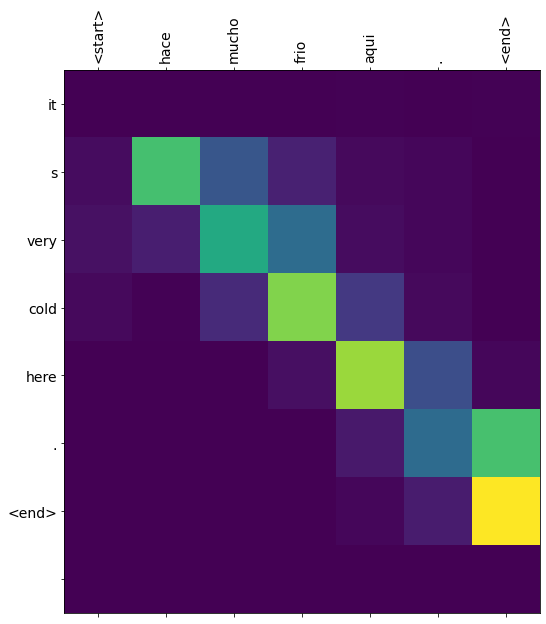

In [ ]:
translate(u'hace mucho frio aqui.')

Input: <start> esta es mi vida . <end>
Predicted translation: this is my life . <end> 


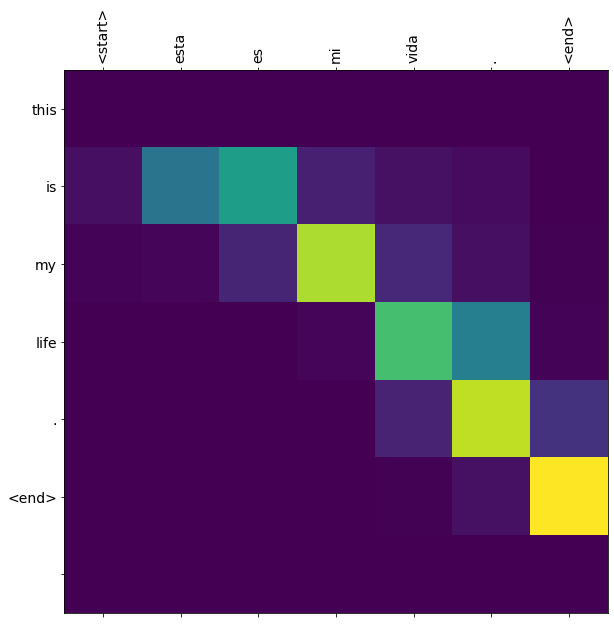

In [ ]:
translate(u'esta es mi vida.')

Input: <start> ¿ todavia estan en casa ? <end>
Predicted translation: are you still at home ? <end> 


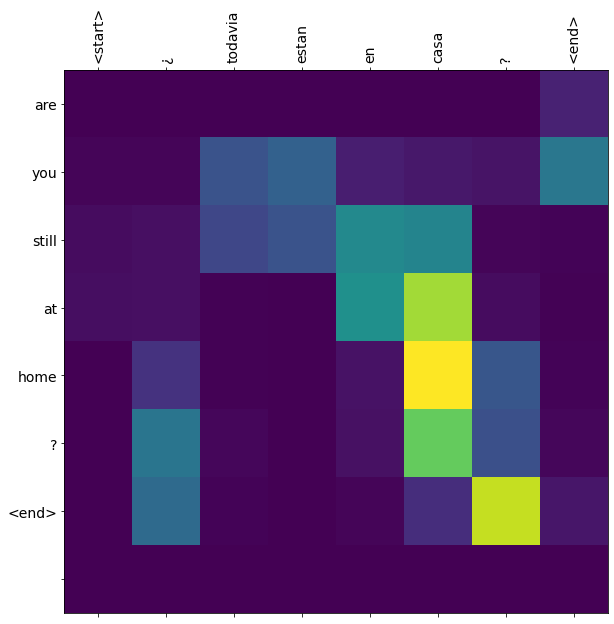

In [ ]:
translate(u'¿todavia estan en casa?')

# Tensorflow.Keras의 model.fit() Vs. Tensorflow Gradient Tape

케라스의 model.fit()과 Gradient Tape()를 사용한 구현의 차이를 이해해봅시다.

##in Tensorflow.Keras

In [ ]:
'''
# 신경망 모델 만들기
model = tf.keras.models.Sequential()
# 완전 연결층을 추가
model.add(tf.keras.layers.Dense(1))
# 옵티마이저와 손실 함수를 지정합니다.
model.compile(optimizer = 'sgd', loss = 'mse')
# 훈련 데이터를 사용하여 에포크 횟수만큼 훈련
model.fit(x_train, y_train, epochs = 10)
'''

"\n# 신경망 모델 만들기\nmodel = tf.keras.models.Sequential()\n# 완전 연결층을 추가\nmodel.add(tf.keras.layers.Dense(1))\n# 옵티마이저와 손실 함수를 지정합니다.\nmodel.compile(optimizer = 'sgd', loss = 'mse')\n# 훈련 데이터를 사용하여 에포크 횟수만큼 훈련\nmodel.fit(x_train, y_train, epochs = 10)\n"

## in Tensorflow

tape_gradient() 메서드는 자동 미분 기능을 수행합니다.  
자동 미분에 대해서 실습을 통해 이해해봅시다. 임의로 2w^2+5라는 식을 세워보고, w에 대해 미분해보겠습니다.

In [ ]:
w = tf.Variable(2.)

def f(w):
  y = w**2
  z = 2*y + 5
  return z

이제 gradients를 출력하면 w가 속한 수식을 w로 미분한 값이 저장된 것을 확인할 수 있습니다.

In [ ]:
with tf.GradientTape() as tape:
  z = f(w)

gradients = tape.gradient(z, [w])
print(gradients)

[<tf.Tensor: shape=(), dtype=float32, numpy=8.0>]


In [ ]:
'''
# 훈련할 가중치 변수를 선언
w = tf.Variable(tf.zeros(shape=(1)))
b = tf.Variable(tf.zeros(shape=(1)))

# 경사 하강법 옵티마이저 설정
optimizer = tf.optimizer.SGD(lr = 0.01)
# 에포크만큼 훈련
num_epochs = 10
for step in range(num_epochs):
   
    # 예측을 해서 손실을 구하는 과정입니다. (자동 미분을 위해 연산 과정을 기록합니다.)
    # tape_gradient() 메서드를 사용하면 그래디언트를 자동으로 계산할 수 있도록 합니다.
    with tf.GradientTape() as tape:
        z_net = w * x_train + b # 정방향 계산
        z_net = tf.reshape(z_net, [-1])
        sqr_errors = tf.square(y_train - z_net)
        mean_cost = tf.reduce_mean(sqr_errors) # 손실을 계산

    # 경사하강법으로 파라미터를 업데이트하는 과정입니다.
    # 1. 가중치에 대한 그래디언트 계산
    grads = tape.gradient(mean_cost, [w, b])

    # 2. 가중치를 업데이트
    # apply_gradients() 메서드에는 그래디언트와 가중치를 튜플로 묶은 리스트를 전달해야 합니다.
    # 보통 zip()을 주로 사용합니다.
    optimizer.apply_gradient(zip(grads, [w, b]))
'''

'\n# 훈련할 가중치 변수를 선언\nw = tf.Variable(tf.zeros(shape=(1)))\nb = tf.Variable(tf.zeros(shape=(1)))\n\n# 경사 하강법 옵티마이저 설정\noptimizer = tf.optimizer.SGD(lr = 0.01)\n# 에포크만큼 훈련\nnum_epochs = 10\nfor step in range(num_epochs):\n   \n    # 예측을 해서 손실을 구하는 과정입니다. (자동 미분을 위해 연산 과정을 기록합니다.)\n    # tape_gradient() 메서드를 사용하면 그래디언트를 자동으로 계산할 수 있도록 합니다.\n    with tf.GradientTape() as tape:\n        z_net = w * x_train + b # 정방향 계산\n        z_net = tf.reshape(z_net, [-1])\n        sqr_errors = tf.square(y_train - z_net)\n        mean_cost = tf.reduce_mean(sqr_errors) # 손실을 계산\n\n    # 경사하강법으로 파라미터를 업데이트하는 과정입니다.\n    # 1. 가중치에 대한 그래디언트 계산\n    grads = tape.gradient(mean_cost, [w, b])\n\n    # 2. 가중치를 업데이트\n    # apply_gradients() 메서드에는 그래디언트와 가중치를 튜플로 묶은 리스트를 전달해야 합니다.\n    # 보통 zip()을 주로 사용합니다.\n    optimizer.apply_gradient(zip(grads, [w, b]))\n'

# 텐서플로우 애드온을 이용한 seq2seq

어텐션 메커니즘과 상관없이 시간이 남으면 보여드리기 위해 추가한 분량.

In [ ]:
from datetime import date

# cannot use strftime()'s %B format since it depends on the locale
MONTHS = ["January", "February", "March", "April", "May", "June",
          "July", "August", "September", "October", "November", "December"]

def random_dates(n_dates):
    min_date = date(1000, 1, 1).toordinal()
    max_date = date(9999, 12, 31).toordinal()

    ordinals = np.random.randint(max_date - min_date, size=n_dates) + min_date
    dates = [date.fromordinal(ordinal) for ordinal in ordinals]

    x = [MONTHS[dt.month - 1] + " " + dt.strftime("%d, %Y") for dt in dates]
    y = [dt.isoformat() for dt in dates]
    return x, y

In [ ]:
np.random.seed(42)

n_dates = 3
x_example, y_example = random_dates(n_dates)
print("{:25s}{:25s}".format("Input", "Target"))
print("-" * 50)
for idx in range(n_dates):
    print("{:25s}{:25s}".format(x_example[idx], y_example[idx]))

Input                    Target                   
--------------------------------------------------
September 20, 7075       7075-09-20               
May 15, 8579             8579-05-15               
January 11, 7103         7103-01-11               


In [ ]:
INPUT_CHARS = "".join(sorted(set("".join(MONTHS)))) + "01234567890, "
INPUT_CHARS

'ADFJMNOSabceghilmnoprstuvy01234567890, '

In [ ]:
OUTPUT_CHARS = "0123456789-"

In [ ]:
def date_str_to_ids(date_str, chars=INPUT_CHARS):
    return [chars.index(c) for c in date_str]

In [ ]:
date_str_to_ids(x_example[0], INPUT_CHARS)

[7, 11, 19, 22, 11, 16, 9, 11, 20, 38, 28, 26, 37, 38, 33, 26, 33, 31]

In [ ]:
date_str_to_ids(y_example[0], OUTPUT_CHARS)

[7, 0, 7, 5, 10, 0, 9, 10, 2, 0]

In [ ]:
def prepare_date_strs(date_strs, chars=INPUT_CHARS):
    X_ids = [date_str_to_ids(dt, chars) for dt in date_strs]
    X = tf.ragged.constant(X_ids, ragged_rank=1)
    return (X + 1).to_tensor() # using 0 as the padding token ID

def create_dataset(n_dates):
    x, y = random_dates(n_dates)
    return prepare_date_strs(x, INPUT_CHARS), prepare_date_strs(y, OUTPUT_CHARS)

In [ ]:
np.random.seed(42)

X_train, Y_train = create_dataset(10000)
X_valid, Y_valid = create_dataset(2000)
X_test, Y_test = create_dataset(2000)

In [ ]:
print(X_train[0])
print(Y_train[0])

tf.Tensor([ 8 12 20 23 12 17 10 12 21 39 29 27 38 39 34 27 34 32], shape=(18,), dtype=int32)
tf.Tensor([ 8  1  8  6 11  1 10 11  3  1], shape=(10,), dtype=int32)


In [ ]:
from tensorflow import keras

텐서플로우 애드온 프로젝트는 여러가지 seq2seq 도구를 포함하고 있어 제품 수준의 seq2seq를 쉽게 만들 수 있습니다.  
우선 인코더의 LSTM에서 return_state=True를 사용한 이후는 디코더에 hidden state를 전달하기 위함입니다.  
LSTM을 사용하므로 cell state, hidden state 두 개를 반환합니다.  

TrainingSampler는 텐서플로우 애드온에 포함되어져 있는 여러 샘플러 중 하나입니다.  
이 샘플러는 각 스텝에서 디코더에게 이전 스텝의 출력이 무엇이었는지 알려줍니다.  
훈련 시에는 이전 타깃 토큰의 임베딩,  
테스트 시에는 실제로 출력되는 토큰의 임베딩입니다.  

In [ ]:
sos_id = len(OUTPUT_CHARS) + 1

def shifted_output_sequences(Y):
    sos_tokens = tf.fill(dims=(len(Y), 1), value=sos_id)
    return tf.concat([sos_tokens, Y[:, :-1]], axis=1)

X_train_decoder = shifted_output_sequences(Y_train)
X_valid_decoder = shifted_output_sequences(Y_valid)
X_test_decoder = shifted_output_sequences(Y_test)

In [ ]:
print(Y_train[0])
print(X_train_decoder[0]) # 종료 토큰 제거 후 시작 토큰 추가

tf.Tensor([ 8  1  8  6 11  1 10 11  3  1], shape=(10,), dtype=int32)
tf.Tensor([12  8  1  8  6 11  1 10 11  3], shape=(10,), dtype=int32)


In [ ]:
import tensorflow_addons as tfa

np.random.seed(42)
tf.random.set_seed(42)

encoder_embedding_size = 32
decoder_embedding_size = 32
units = 128

encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

encoder_embeddings = keras.layers.Embedding(
    len(INPUT_CHARS) + 1, encoder_embedding_size)(encoder_inputs)

decoder_embedding_layer = keras.layers.Embedding(
    len(INPUT_CHARS) + 2, decoder_embedding_size)
decoder_embeddings = decoder_embedding_layer(decoder_inputs)

encoder = keras.layers.LSTM(units, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

sampler = tfa.seq2seq.sampler.TrainingSampler()

decoder_cell = keras.layers.LSTMCell(units)
output_layer = keras.layers.Dense(len(OUTPUT_CHARS) + 1)

decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell,
                                                 sampler,
                                                 output_layer=output_layer)
final_outputs, final_state, final_sequence_lengths = decoder(
    decoder_embeddings,
    initial_state=encoder_state)
Y_proba = keras.layers.Activation("softmax")(final_outputs.rnn_output)

model = keras.models.Model(inputs=[encoder_inputs, decoder_inputs],
                           outputs=[Y_proba])
optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit([X_train, X_train_decoder], Y_train, epochs=15,
                    validation_data=([X_valid, X_valid_decoder], Y_valid))

Epoch 1/15
313/313 [==============================] - 13s 43ms/step - loss: 1.6781 - accuracy: 0.3686 - val_loss: 1.4550 - val_accuracy: 0.4323
Epoch 2/15
313/313 [==============================] - 12s 39ms/step - loss: 1.3495 - accuracy: 0.4807 - val_loss: 1.3177 - val_accuracy: 0.4956
Epoch 3/15
313/313 [==============================] - 12s 40ms/step - loss: 0.9140 - accuracy: 0.6711 - val_loss: 0.6418 - val_accuracy: 0.7683
Epoch 4/15
313/313 [==============================] - 12s 40ms/step - loss: 0.3948 - accuracy: 0.8769 - val_loss: 0.2228 - val_accuracy: 0.9464
Epoch 5/15
313/313 [==============================] - 12s 39ms/step - loss: 0.1208 - accuracy: 0.9807 - val_loss: 0.0676 - val_accuracy: 0.9938
Epoch 6/15
313/313 [==============================] - 12s 39ms/step - loss: 0.0902 - accuracy: 0.9866 - val_loss: 0.0449 - val_accuracy: 0.9973
Epoch 7/15
313/313 [==============================] - 12s 40ms/step - loss: 0.0261 - accuracy: 0.9994 - val_loss: 0.0200 - val_accuracy:

KeyboardInterrupt: ignored

In [ ]:
def ids_to_date_strs(ids, chars=OUTPUT_CHARS):
    return ["".join([("?" + chars)[index] for index in sequence])
            for sequence in ids]

In [ ]:
max_output_length = Y_train.shape[1]

In [ ]:
max_input_length = X_train.shape[1]

def prepare_date_strs_padded(date_strs):
    X = prepare_date_strs(date_strs)
    if X.shape[1] < max_input_length:
        X = tf.pad(X, [[0, 0], [0, max_input_length - X.shape[1]]])
    return X

def convert_date_strs(date_strs):
    X = prepare_date_strs_padded(date_strs)
    ids = model.predict_classes(X)
    return ids_to_date_strs(ids)

In [ ]:
sos_id = len(OUTPUT_CHARS) + 1

def predict_date_strs(date_strs):
    X = prepare_date_strs_padded(date_strs)
    Y_pred = tf.fill(dims=(len(X), 1), value=sos_id)
    for index in range(max_output_length):
        pad_size = max_output_length - Y_pred.shape[1]
        X_decoder = tf.pad(Y_pred, [[0, 0], [0, pad_size]])
        Y_probas_next = model.predict([X, X_decoder])[:, index:index+1]
        Y_pred_next = tf.argmax(Y_probas_next, axis=-1, output_type=tf.int32)
        Y_pred = tf.concat([Y_pred, Y_pred_next], axis=1)
    return ids_to_date_strs(Y_pred[:, 1:])

In [ ]:
predict_date_strs(["July 14, 1789", "May 01, 2020"])

['1789-07-14', '2020-05-01']